In [2]:
import pandas as pd

In [3]:
datas=['BTC-USD','LTC-USD','ETH-USD','BCH-USD']
main_df=[]
for data in datas:
    dataset=f'./crypto_data/{data}.csv'
    df=pd.read_csv(dataset)
    df.rename(columns={"Close":f"{data}_close","Volume":f"{data}_volume"},inplace=True)
    df.set_index('Timestamp',inplace=True)
    df=df[[f"{data}_close",f"{data}_volume"]]
    #df.head()
    if len(main_df)==0:
        main_df=df
    else:
        main_df=main_df.join(df)

In [40]:
main_df.head()

,BTC-USD_close,BTC-USD_volume,LTC-USD_close,LTC-USD_volume,ETH-USD_close,ETH-USD_volume,BCH-USD_close,BCH-USD_volume
Timestamp,,,,,,,,
1528968660,6489.549805,0.587100,96.580002,9.647200,NaN,NaN,871.719971,5.675361
1528968720,6487.379883,7.706374,96.660004,314.387024,486.01001,26.019083,870.859985,26.856577
1528968780,6479.410156,3.088252,96.570000,77.129799,486.00000,8.449400,870.099976,1.124300
1528968840,6479.410156,1.404100,96.500000,7.216067,485.75000,26.994646,870.789978,1.749862
1528968900,6479.979980,0.753000,96.389999,524.539978,486.00000,77.355759,870.000000,1.680500


In [41]:
main_df.sort_values('Timestamp')

,BTC-USD_close,BTC-USD_volume,LTC-USD_close,LTC-USD_volume,ETH-USD_close,ETH-USD_volume,BCH-USD_close,BCH-USD_volume
Timestamp,,,,,,,,
1528968660,6489.549805,0.587100,96.580002,9.647200,NaN,NaN,871.719971,5.675361
1528968720,6487.379883,7.706374,96.660004,314.387024,486.010010,26.019083,870.859985,26.856577
1528968780,6479.410156,3.088252,96.570000,77.129799,486.000000,8.449400,870.099976,1.124300
1528968840,6479.410156,1.404100,96.500000,7.216067,485.750000,26.994646,870.789978,1.749862
1528968900,6479.979980,0.753000,96.389999,524.539978,486.000000,77.355759,870.000000,1.680500
...,...,...,...,...,...,...,...,...
1535214960,6713.140137,0.769891,58.020000,6.434783,279.359985,11.280577,531.479980,1.208560
1535215020,6714.520020,1.002652,58.009998,7.301921,279.359985,8.790519,531.479980,0.016868
1535215080,6714.520020,1.021925,58.020000,23.802017,279.369995,1.311763,531.469971,0.013854


In [0]:
def decision(current,future):
    if current<future:
        return 1
    else:
        return 0
#buy if decision is 1

In [0]:
main_df.dropna(inplace=True)

In [0]:
seq=60#we'll take last 60 minutes sequence
future_period_predict=3#minutes 
ratio_to_predict='LTC-USD'

In [0]:
main_df['future']=main_df[f"{ratio_to_predict}_close"].shift(-future_period_predict)

In [0]:
main_df['target']=list(map(decision,main_df[f"{ratio_to_predict}_close"],main_df['future']))

In [47]:
print(main_df[[f"{ratio_to_predict}_close","future",'target']])

            LTC-USD_close     future  target
Timestamp                                   
1528968720      96.660004  96.389999       0
1528968780      96.570000  96.519997       0
1528968840      96.500000  96.440002       0
1528968900      96.389999  96.470001       1
1528968960      96.519997  96.400002       0
...                   ...        ...     ...
1535214960      58.020000  58.020000       0
1535215020      58.009998  58.080002       1
1535215080      58.020000        NaN       0
1535215140      58.020000        NaN       0
1535215200      58.080002        NaN       0

[86117 rows x 3 columns]


In [48]:
print(main_df[[f"{ratio_to_predict}_close","future",'target']])

            LTC-USD_close     future  target
Timestamp                                   
1528968720      96.660004  96.389999       0
1528968780      96.570000  96.519997       0
1528968840      96.500000  96.440002       0
1528968900      96.389999  96.470001       1
1528968960      96.519997  96.400002       0
...                   ...        ...     ...
1535214960      58.020000  58.020000       0
1535215020      58.009998  58.080002       1
1535215080      58.020000        NaN       0
1535215140      58.020000        NaN       0
1535215200      58.080002        NaN       0

[86117 rows x 3 columns]


In [0]:
main_df.dropna(inplace=True)

In [0]:
train_main_df,test_main_df=main_df[int((0.05)*len(main_df)):],main_df[81809:]

In [0]:
from sklearn import preprocessing
from collections import deque
import numpy as np
import random
def preprocess_df(df):
    df=df.drop('future',axis=1)
    for col in df.columns:
        if col !='target':
            df[col]=df[col].pct_change()
            df.dropna(inplace=True)
            df[col]=preprocessing.scale(df[col].values)
    df.dropna(inplace=True) 
    sequential_data=[]
    prev_days=deque(maxlen=seq)
    
    for z in df.values:
        prev_days.append([x for x in z[:-1]])
        if len(prev_days)==seq:
            sequential_data.append([np.array(prev_days),z[-1]])
    random.shuffle(sequential_data)

    buys=[]
    sells=[]
    for seqs,target in sequential_data:
        if target == 0:
            sells.append([seqs,target])
        elif target==1:
            buys.append([seqs,target])
    lwer=min(len(buys),len(sells))
    
    buys=buys[:lwer]
    sells=sells[:lwer]
    sequential_data=buys+sells
    random.shuffle(sequential_data)
    X=[]
    y=[]
    for seqs,target in sequential_data:
        X.append(seqs)
        y.append(target)
    return np.array(X),np.array(y)

In [0]:
train_x,train_y=preprocess_df(train_main_df)
valid_x,valid_y=preprocess_df(test_main_df)

In [0]:
#model::
Epochs=10
BS=64
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Dense,LSTM,BatchNormalization

In [0]:
import tensorflow as tf
model=Sequential()
model.add(LSTM(128,input_shape=(train_x.shape[1:]),return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128,input_shape=(train_x.shape[1:]),return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128,input_shape=(train_x.shape[1:])))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32,activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(2,activation='softmax'))

opti=tf.keras.optimizers.Adam(lr=0.001,decay=1e-6)


In [0]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=opti,metrics=['accuracy'])

In [57]:
history=model.fit(train_x,train_y,epochs=Epochs,batch_size=BS,validation_data=(valid_x,valid_y))

Epoch 1/10
1097/1097 [==============================] - 65s 59ms/step - loss: 0.7106 - accuracy: 0.5218 - val_loss: 0.6819 - val_accuracy: 0.5518
Epoch 2/10
1097/1097 [==============================] - 62s 57ms/step - loss: 0.6856 - accuracy: 0.5520 - val_loss: 0.6809 - val_accuracy: 0.5624
Epoch 3/10
1097/1097 [==============================] - 61s 56ms/step - loss: 0.6830 - accuracy: 0.5597 - val_loss: 0.6788 - val_accuracy: 0.5753
Epoch 4/10
1097/1097 [==============================] - 60s 54ms/step - loss: 0.6812 - accuracy: 0.5655 - val_loss: 0.6798 - val_accuracy: 0.5649
Epoch 5/10
1097/1097 [==============================] - 58s 53ms/step - loss: 0.6803 - accuracy: 0.5652 - val_loss: 0.6744 - val_accuracy: 0.5778
Epoch 6/10
1097/1097 [==============================] - 57s 52ms/step - loss: 0.6784 - accuracy: 0.5697 - val_loss: 0.6754 - val_accuracy: 0.5750
Epoch 7/10
1097/1097 [==============================] - 56s 51ms/step - loss: 0.6763 - accuracy: 0.5756 - val_loss: 0.6674 -

In [0]:
import matplotlib.pyplot as plt


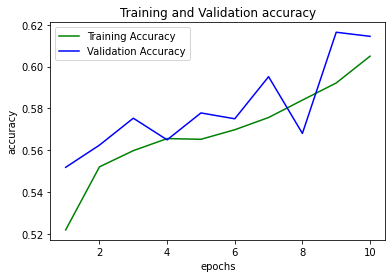

In [69]:

epochs=range(1,11)
plt.plot(epochs,history.history['accuracy'],'g',label='Training Accuracy')
plt.plot(epochs,history.history['val_accuracy'],'b',label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

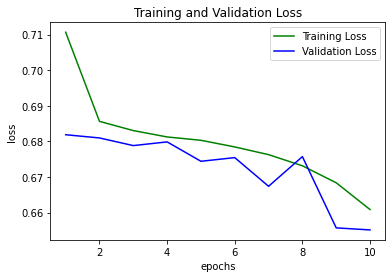

In [71]:
plt.plot(epochs,history.history['loss'],'g',label='Training Loss')
plt.plot(epochs,history.history['val_loss'],'b',label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
